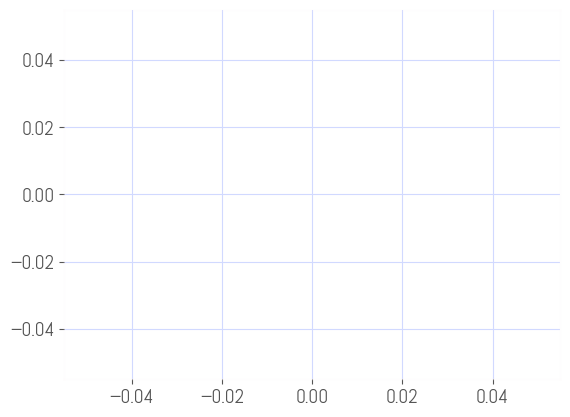

0-element Array{Any,1}

In [67]:
using DataFrames, CSV, PyPlot, PorousMaterials

PyPlot.matplotlib.font_manager.fontManager.addfont("Abel-Regular.ttf")
PyPlot.matplotlib.style.use("grandbudapest.mplstyle")

plot()

# methane adsorption HKUST-1 and MOF-5
read in adsorption data, covert uptake to mmol/g

In [68]:
mofs = ["HKUST-1", "MOF-5"]
df = Dict{String, DataFrame}()
for mof in mofs
    df[mof] = CSV.read("ch4_" * mof * "_25C.csv", comment="#")
    df[mof][!, :N_mmol_g] = df[mof][:, Symbol("N(cm3/g)")] / 22.4
end
first(df[mofs[1]], 3)

,P(bar),N(cm3/g),N_mmol_g
,Float64,Float64,Float64
1,0.68,15.52,0.692857
2,1.72,34.43,1.53705
3,3.55,62.79,2.80313


fit Langmuir model

In [69]:
params = Dict(mof => fit_adsorption_isotherm(df[mof], Symbol("P(bar)"), :N_mmol_g, :langmuir) for mof in mofs)

Dict{String,Dict{String,Float64}} with 2 entries:
  "MOF-5"   => Dict("M"=>32.2469,"K"=>0.0139923,"MSE"=>0.0322526)
  "HKUST-1" => Dict("M"=>16.6781,"K"=>0.0600375,"MSE"=>0.00464618)

In [70]:
m(p::Float64, mof::String) = params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p)

m (generic function with 1 method)

plot data with Langmuir fit

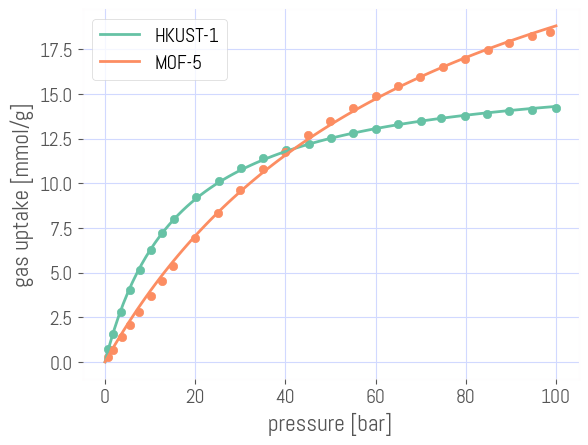

PyObject Text(33.500000000000014, 0.5, 'gas uptake [mmol/g]')

In [71]:
figure()
p = range(0.0, 100.0, length=100)
for mof in mofs
    scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :N_mmol_g])
    plot(p, m.(p, mof), label=mof)
end
legend()
xlabel("pressure [bar]")
ylabel("gas uptake [mmol/g]")

# illustrate $\delta m$

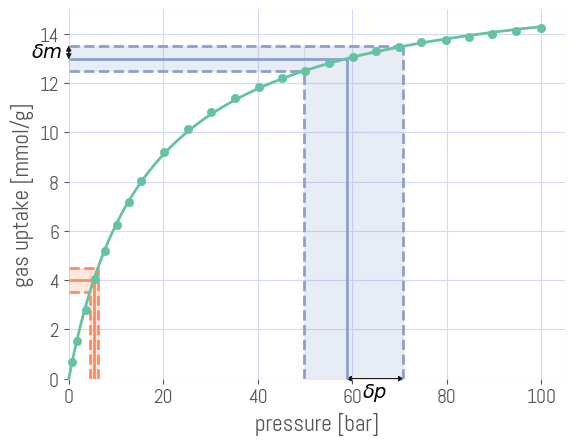

PyObject Text(33.50000000000001, 0.5, 'gas uptake [mmol/g]')

In [102]:
δm = 1.0
ms = [4.0, 13.0]
g(m::Float64, mof::String) = 1 / params[mof]["K"] * m / (params[mof]["M"] - m) # inverse

figure()
p = range(0.0, 100.0, length=100)
mof = "HKUST-1"
scatter(df[mof][:, Symbol("P(bar)")], df[mof][:, :N_mmol_g], zorder=1000, clip_on=false)
plot(p, params[mof]["M"] * params[mof]["K"] * p ./ (1 .+ params[mof]["K"] * p), label=mof, zorder=1000, clip_on=false)
for (i, m) in enumerate(ms)
    p = g(m, mof)
    plot([p, p], [0, m], color="C$i")
    plot([0, p], [m, m], color="C$i")
    m_low = m - δm / 2
    m_high = m + δm / 2
    p_low = g(m_low, mof)
    p_high = g(m_high, mof)
    plot([p_low, p_low], [0, m_low], linestyle="--", color="C$i")
    plot([0, p_low], [m_low, m_low], linestyle="--", color="C$i")
    plot([p_high, p_high], [0, m_high], linestyle="--", color="C$i")
    plot([0, p_high], [m_high, m_high], linestyle="--", color="C$i")
    
    ps = range(p_low, p_high, length=200)
    fill_between(ps, [m_high for _ = 1:length(ps)], alpha=0.2, color="C$i")
    fill_between([0.0, p_low], [m_low, m_low], [m_high, m_high], alpha=0.2, color="C$i")
    if i == 2
        arrow(0.0, m, 0.0, δm/2, length_includes_head=true,
          head_width=1, head_length=0.2, clip_on=false, color="k")
        arrow(0.0, m+δm/2, 0.0, -δm/2, length_includes_head=true,
          head_width=1, head_length=0.2, clip_on=false, color="k")
        text(-8.0, m + δm / 4, L"$\delta m$", verticalalignment="center")
        
        arrow(p, 0.0, p_high-p, 0.0, length_includes_head=true,
          head_width=0.2, head_length=1, clip_on=false, color="k")
        arrow(p_high, 0.0, p-p_high, 0.0, length_includes_head=true,
          head_width=0.2, head_length=1, clip_on=false, color="k")
        text(p + (p_high-p)/2, -0.75, L"$\delta p$", horizontalalignment="center")
    end
end

xlim(xmin=0.0)
ylim(ymin=0.0)
xlabel("pressure [bar]")
ylabel("gas uptake [mmol/g]")
